# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [ ]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

In [ ]:
out_dir = out_dir = '../data/out_dev/'

In [ ]:
nx0 = imgs0.shape[1]
nx_crop = 128
N = 80000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[2135].reshape([128,128]))));plt.colorbar()

In [ ]:
del(imgs0)

### Only volume reconstruction for now - SGD

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different

In [ ]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
alpha = 1e-9

slice_obj = Slice(x_grid)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

#### SGD

In [ ]:
N_epochs = 20
batch_size = 32
step_size = 1000000 # 1e-3

idxrand = np.random.permutation(N)
idx1 = idxrand[:int(N/2)]
idx2 = idxrand[int(N/2):]
             
grad_func1, loss_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, N//2, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


In [ ]:
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, N//2, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


In [ ]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); #plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); #plt.colorbar()

In [ ]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

#### OASIS

In [ ]:
idxrand = np.random.permutation(N)
idx1 = idxrand[:int(N/2)]
idx2 = idxrand[int(N/2):]
             
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
angles1 = angles[idx1]
shifts1 = shifts[idx1]
ctf_params1 = ctf_params[idx1]
imgs1 = imgs_f[idx1]

angles2 = angles[idx2]
shifts2 = shifts[idx2]
ctf_params2 = ctf_params[idx2]
imgs2 = imgs_f[idx2]

In [ ]:
# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))


In [ ]:
def hvp_loss_func(v, x, angles, shifts, ctf_params, imgs, sigma_noise):
    return hvp(lambda u : loss_obj.loss_sum(u, angles, shifts, ctf_params, imgs, sigma_noise), (v,), (x,))[1]

Fidx = lambda v, idx : loss_obj.loss_sum(v, angles1[idx,:], shifts1[idx,:], ctf_params1[idx,:], imgs1[idx,:], sigma_noise)
gradFidx = lambda v, idx : gradv_obj.grad_loss_volume_sum(v, angles1[idx,:], shifts1[idx,:], ctf_params1[idx,:], imgs1[idx,:], sigma_noise)
hvpFidx = lambda v, x, idx : hvp_loss_func(v, x, angles1[idx,:], shifts1[idx,:], ctf_params1[idx,:], imgs1[idx,:], sigma_noise)



In [ ]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good

iters = 1000
batch_sz = 1000
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros([nx,nx,nx])

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], [nx,nx,nx], dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N//2)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)

In [ ]:
mip_x(jnp.fft.fftshift(jnp.abs(D0))); plt.colorbar()

In [ ]:
N_epoch = 4
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
batch_size = 32
alpha = 0.1 # 0.01

In [ ]:
key, subkey = random.split(key)
v_rec_o1, loss_o1 = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


In [ ]:
mip_z(np.fft.fftshift(np.abs(v_rec_o1))); 
plt.colorbar()

In [ ]:
v_rec_ol1, _ = rescale_larger_grid(v_rec_o1, x_grid, nx0)
vr_o1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol1)))

mip_z(vr_o1)
plt.colorbar()

In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_o1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o1.astype(np.float32))
    

In [ ]:
out_dir

#### FSC

In [ ]:
print(v_rec1.shape)
print(v_rec2.shape)
print(x_grid)

In [ ]:
res, fsc, shell_points = calc_fsc(v_rec1, v_rec2, [1, 128])

In [ ]:
plt.plot(res, fsc)

In [ ]:
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc)

In [ ]:
fsc

In [ ]:
fsc[10]

In [ ]:
fsc[11]

In [ ]:
res_angs[10]

In [ ]:
res_angs[11]

### Newton's method vs GD vs CG

#### GD - a pain to tune 

In [ ]:
Ngd = 1000

N_epochs = 200
batch_size = Ngd
step_size = 10000 # 1e-3

idx = np.arange(Ngd)

grad_func, loss_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec_gd, loss_rec_gd, grad_rec_gd = sgd(grad_func, loss_func1, Ngd, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=10)


In [ ]:
plt.plot(loss_rec_gd)

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [3]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

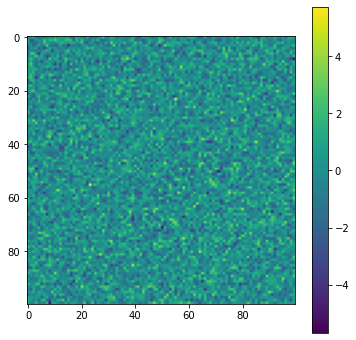

In [4]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n))
A = A.T + A

plt.imshow(A); plt.colorbar()

In [5]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [6]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [7]:
d = np.zeros((iters, n))
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [8]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

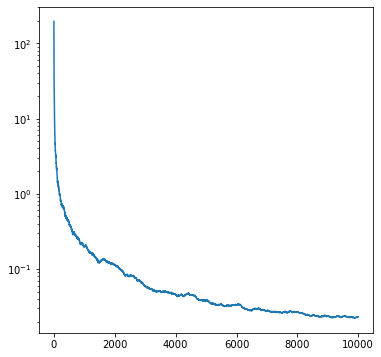

In [9]:
plt.semilogy(err)

#### Hessian-vector product in JaX

In [10]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [11]:
b = A @ x0 
f = lambda x : jnp.mean((A @ x - b)**2)

In [12]:
f(x0)

DeviceArray(0., dtype=float64)

In [13]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [14]:
t0 = time.time()
v1 = hvp0(f, x, v).block_until_ready()
print(time.time()-t0)

t0 = time.time()
v2 = hvp(f, (x,), (v,)).block_until_ready()
print(time.time()-t0)

jnp.sum(jnp.abs(v1-v2))

1.0637695789337158
0.5336849689483643


DeviceArray(0., dtype=float64)

#### Toy problem

Condition number =  3.33e+05


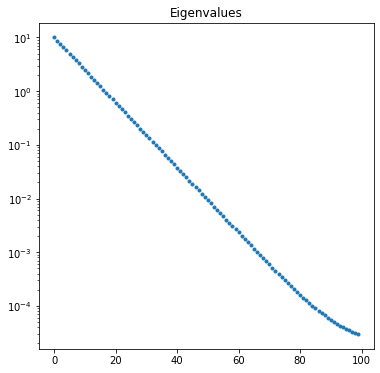

In [15]:
key, *subkey = random.split(key, 4)

x_gt = random.normal(subkey[0], (n,))

A = np.random.normal(size = (n,n))
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)


plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [65]:
sig_noise = 1
lam = 0.1

b = A @ x_gt  + np.random.normal(size=(n,)) * sig_noise

F = jax.jit(lambda x : jnp.sum((A @ x - b)**2) + lam * jnp.mean(x**2))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
print(f"hessianF(x_gt) = {hessianF(x_gt)}")


f(x_gt + 1) = 633.032181535458
f(x_gt) = 101.89051874563971
gradF(x_gt) = [ -4.8468398    0.57294406  -2.79585158   7.67356151  -3.06860587
  -8.56468141  -0.86076903   4.23711059   7.25582725   1.48148951
   6.17963521  -9.16768843  -6.93161154   2.59059661  -0.22028783
   4.36887966   4.55282107 -13.09058523  -4.10779426 -10.98591985
  -5.56525641   6.56991833   2.33250839  -3.96395197  -0.16411889
  -0.62918493  -8.00802721   4.34514098  10.39930328   6.75465174
   2.84862657  -2.58822979   1.63091453   3.99597514   9.20471954
   4.11959064  12.61727147  -1.30685052  -6.77814888   1.87884778
   6.13958903   3.33377737   1.15021511  -1.95187491  -8.13040862
  -2.64930426   9.92291675  -1.41374732  -8.42217815   2.0452522
  -7.13898169   2.4192096   -0.70403804  10.52737281  -7.15726227
  -2.41242545   6.06464455   2.36030979  -0.88288279  -2.01296148
  -5.21082988   6.52377941  -4.13939091   0.48428692   2.96723118
  -0.28833334   5.25443906   1.63048247 -10.24163623   3.486784
   6.

In [66]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * gradF(w0)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.linalg.inv(H) @ G
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [67]:
N_iter = 10000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

Iter 200: loss = 85.89062382488059
Iter 400: loss = 80.95893161657101
Iter 600: loss = 78.50445600498816
Iter 800: loss = 76.80103131395377
Iter 1000: loss = 75.46367270246294
Iter 1200: loss = 74.36038427955197
Iter 1400: loss = 73.42689675396343
Iter 1600: loss = 72.62386884166668
Iter 1800: loss = 71.92424657258933
Iter 2000: loss = 71.3082955731706
Iter 2200: loss = 70.76110691107954
Iter 2400: loss = 70.27113713540705
Iter 2600: loss = 69.82927769946836
Iter 2800: loss = 69.42823069049996
Iter 3000: loss = 69.06207468282489
Iter 3200: loss = 68.72595402956695
Iter 3400: loss = 68.41585105436309
Iter 3600: loss = 68.12841552092333
Iter 3800: loss = 67.86083467851664
Iter 4000: loss = 67.61073269761324
Iter 4200: loss = 67.37609181689994
Iter 4400: loss = 67.15518980931543
Iter 4600: loss = 66.94654990115062
Iter 4800: loss = 66.74890032036095
Iter 5000: loss = 66.5611413767943
Iter 5200: loss = 66.382318493516
Iter 5400: loss = 66.21159998209683
Iter 5600: loss = 66.04825862943214


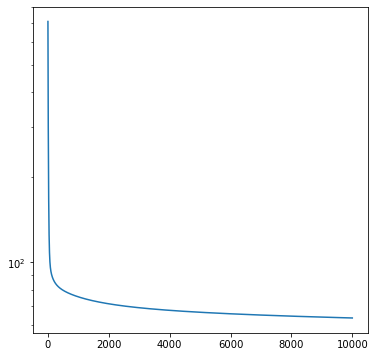

In [68]:
plt.semilogy(loss_gd)

In [69]:
N_iter = 10

x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

Iter 1: loss = 53.49107659339501
Iter 2: loss = 53.49107659339502
Iter 3: loss = 53.49107659339505
Iter 4: loss = 53.491076593395015
Iter 5: loss = 53.49107659339502
Iter 6: loss = 53.491076593395015
Iter 7: loss = 53.49107659339505
Iter 8: loss = 53.491076593395015
Iter 9: loss = 53.491076593395036
Iter 10: loss = 53.491076593395


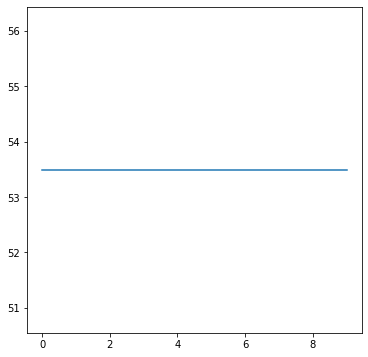

In [70]:
plt.plot(loss_n)

In [71]:
N_iter = 10000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk = cg(AA, Ab, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 190.65225156390463
  cg iter 200 ||r|| = 3.60973239407645e-05
  cg iter 400 ||r|| = 1.2885717436175428e-09
  cg iter 600 ||r|| = 4.493021255089912e-12
  cg iter 800 ||r|| = 3.189379310693982e-13
  cg iter 1000 ||r|| = 3.089642489960247e-13
  cg iter 1200 ||r|| = 2.419669267664187e-13
  cg iter 1400 ||r|| = 1.9795511943297753e-13
  cg iter 1600 ||r|| = 2.4722537894048003e-13
  cg iter 1800 ||r|| = 1.7367604615439458e-13
  cg iter 2000 ||r|| = 2.178450085611817e-13
  cg iter 2200 ||r|| = 1.0988216651776777e-13
  cg iter 2400 ||r|| = 1.3446154258886069e-13
  cg iter 2600 ||r|| = 2.413955094882041e-13
  cg iter 2800 ||r|| = 2.2662188142374713e-13
  cg iter 3000 ||r|| = 1.1412643752634652e-13
  cg iter 3200 ||r|| = 2.9179037421076643e-13
  cg iter 3400 ||r|| = 1.1610020546815167e-13
  cg iter 3600 ||r|| = 1.589593127603337e-13
  cg iter 3800 ||r|| = 1.0514169826749076e-13
  cg iter 4000 ||r|| = 1.3169054004152293e-13
  cg iter 4200 ||r|| = 7.982244946789268e-14
  cg iter

In [72]:
F(x_cg)

DeviceArray(53.49107659, dtype=float64)

#### OASIS

In [73]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [74]:
# Estimating D0

iters = 100
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


100%|██████████| 100/100 [00:00<00:00, 957.28it/s]


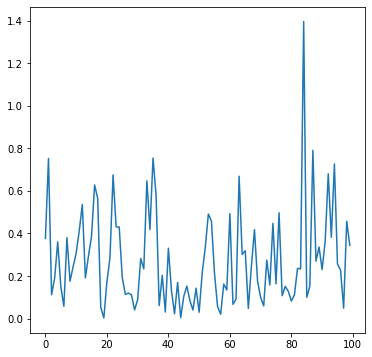

In [76]:
plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [79]:
N_iter = 10000
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 500)


Epoch 500/10000


100%|██████████| 1/1 [00:00<00:00, 131.73it/s, loss=7.669e+01]

  Loss =  7.669e+01


Epoch 1000/10000


100%|██████████| 1/1 [00:00<00:00, 190.06it/s, loss=7.281e+01]

  Loss =  7.281e+01


Epoch 1500/10000


100%|██████████| 1/1 [00:00<00:00, 144.86it/s, loss=7.059e+01]

  Loss =  7.059e+01


Epoch 2000/10000


100%|██████████| 1/1 [00:00<00:00, 196.09it/s, loss=6.909e+01]

  Loss =  6.909e+01


Epoch 2500/10000


100%|██████████| 1/1 [00:00<00:00, 58.02it/s, loss=6.798e+01]

  Loss =  6.798e+01


Epoch 3000/10000


100%|██████████| 1/1 [00:00<00:00, 195.63it/s, loss=6.710e+01]

  Loss =  6.710e+01


Epoch 3500/10000


100%|██████████| 1/1 [00:00<00:00, 203.26it/s, loss=6.638e+01]

  Loss =  6.638e+01


Epoch 4000/10000


100%|██████████| 1/1 [00:00<00:00, 189.30it/s, loss=6.577e+01]

  Loss =  6.577e+01


Epoch 4500/10000


100%|██████████| 1/1 [00:00<00:00, 285.56it/s, loss=6.525e+01]

  Loss =  6.525e+01


Epoch 5000/10000


100%|██████████| 1/1 [00:00<00:00, 256.02it/s, loss=6.478e+01]

  Loss =  6.478e+01


Epoch 5500/10000


100%|██████████| 1/1 [00:00<00:00, 169.11it/s, loss=6.436e+01]

  Loss =  6.436e+01


Epoch 6000/10000


100%|██████████| 1/1 [00:00<00:00, 112.66it/s, loss=6.399e+01]

  Loss =  6.399e+01


Epoch 6500/10000


100%|██████████| 1/1 [00:00<00:00, 170.69it/s, loss=6.364e+01]

  Loss =  6.364e+01


Epoch 7000/10000


100%|██████████| 1/1 [00:00<00:00, 203.22it/s, loss=6.332e+01]

  Loss =  6.332e+01


Epoch 7500/10000


100%|██████████| 1/1 [00:00<00:00, 272.09it/s, loss=6.302e+01]

  Loss =  6.302e+01


Epoch 8000/10000


100%|██████████| 1/1 [00:00<00:00, 189.76it/s, loss=6.275e+01]

  Loss =  6.275e+01


Epoch 8500/10000


100%|██████████| 1/1 [00:00<00:00, 186.38it/s, loss=6.249e+01]

  Loss =  6.249e+01


Epoch 9000/10000


100%|██████████| 1/1 [00:00<00:00, 153.05it/s, loss=6.224e+01]

  Loss =  6.224e+01


Epoch 9500/10000


100%|██████████| 1/1 [00:00<00:00, 219.48it/s, loss=6.201e+01]

  Loss =  6.201e+01


Epoch 10000/10000


100%|██████████| 1/1 [00:00<00:00, 138.82it/s, loss=6.179e+01]

  Loss =  6.179e+01


In [82]:
N_iter = 10000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


Epoch 500/10000


100%|██████████| 1/1 [00:00<00:00, 152.99it/s, loss=6.467e+01]

  Loss =  6.467e+01


Epoch 1000/10000


100%|██████████| 1/1 [00:00<00:00, 236.85it/s, loss=6.158e+01]

  Loss =  6.158e+01


Epoch 1500/10000


100%|██████████| 1/1 [00:00<00:00, 161.71it/s, loss=5.987e+01]

  Loss =  5.987e+01


Epoch 2000/10000


100%|██████████| 1/1 [00:00<00:00, 133.48it/s, loss=5.874e+01]

  Loss =  5.874e+01


Epoch 2500/10000


100%|██████████| 1/1 [00:00<00:00, 144.59it/s, loss=5.796e+01]

  Loss =  5.796e+01


Epoch 3000/10000


100%|██████████| 1/1 [00:00<00:00, 99.50it/s, loss=5.734e+01]

  Loss =  5.734e+01


Epoch 3500/10000


100%|██████████| 1/1 [00:00<00:00, 205.72it/s, loss=5.688e+01]

  Loss =  5.688e+01


Epoch 4000/10000


100%|██████████| 1/1 [00:00<00:00, 148.95it/s, loss=5.650e+01]

  Loss =  5.650e+01


Epoch 4500/10000


100%|██████████| 1/1 [00:00<00:00, 131.08it/s, loss=5.620e+01]

  Loss =  5.620e+01


Epoch 5000/10000


100%|██████████| 1/1 [00:00<00:00, 137.10it/s, loss=5.595e+01]

  Loss =  5.595e+01


Epoch 5500/10000


100%|██████████| 1/1 [00:00<00:00, 143.77it/s, loss=5.574e+01]

  Loss =  5.574e+01


Epoch 6000/10000


100%|██████████| 1/1 [00:00<00:00, 160.03it/s, loss=5.556e+01]

  Loss =  5.556e+01


Epoch 6500/10000


100%|██████████| 1/1 [00:00<00:00, 147.42it/s, loss=5.541e+01]

  Loss =  5.541e+01


Epoch 7000/10000


100%|██████████| 1/1 [00:00<00:00, 149.20it/s, loss=5.528e+01]

  Loss =  5.528e+01


Epoch 7500/10000


100%|██████████| 1/1 [00:00<00:00, 132.96it/s, loss=5.517e+01]

  Loss =  5.517e+01


Epoch 8000/10000


100%|██████████| 1/1 [00:00<00:00, 150.08it/s, loss=5.507e+01]

  Loss =  5.507e+01


Epoch 8500/10000


100%|██████████| 1/1 [00:00<00:00, 143.92it/s, loss=5.497e+01]

  Loss =  5.497e+01


Epoch 9000/10000


100%|██████████| 1/1 [00:00<00:00, 180.94it/s, loss=5.489e+01]

  Loss =  5.489e+01


Epoch 9500/10000


100%|██████████| 1/1 [00:00<00:00, 140.78it/s, loss=5.482e+01]

  Loss =  5.482e+01


Epoch 10000/10000


100%|██████████| 1/1 [00:00<00:00, 150.36it/s, loss=5.475e+01]

  Loss =  5.475e+01


14.694535531267231
14.694535531496772
3.155089538790465
5.4780638312609025
12.531598845080955


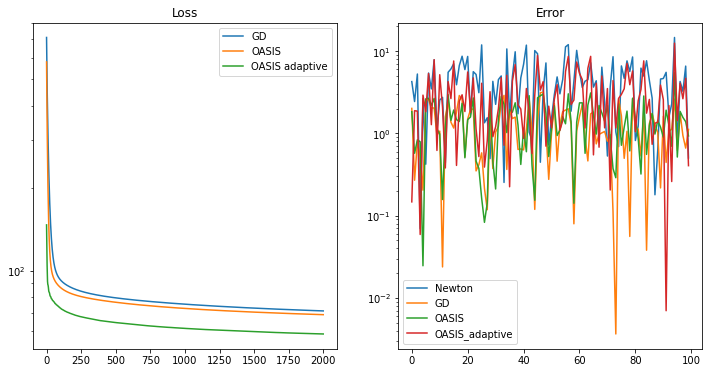

In [83]:
print(jnp.max(jnp.abs(x_gt-x_n)))
print(jnp.max(jnp.abs(x_gt-x_cg)))
print(jnp.max(jnp.abs(x_gt-x_gd)))
print(jnp.max(jnp.abs(x_gt-x_o)))
print(jnp.max(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 2000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["Newton", "GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [84]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to do SGD/OASIS on:

In [110]:
sig_noise = 10
lam = 0.1

In [111]:
n = 100
N = 1000

x_gt = np.random.normal(size=(n,))

ops = []
b = []
for i in range(N):
    A = np.random.normal(size=(n,n))
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.flip(jnp.logspace(-5,4,n)) + np.random.normal(size=(n,))*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + np.random.normal(size=(n,)) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [112]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

 4.41e+02


In [113]:
def loss_term(x, A, b):
    return 1/2 * jnp.mean((A@x - b)**2) + lam * jnp.mean(x**2)

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [114]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

57.90262665146361
50.22847671827418
(100,)
(100,)
(100,)
(100,)


In [115]:
hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = jnp.array(np.random.randn(n))

In [116]:
Fidx(x_gt, jnp.arange(N))

DeviceArray(50.22847672, dtype=float64)

In [117]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good

iters = 100
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


100%|██████████| 100/100 [00:01<00:00, 61.13it/s]


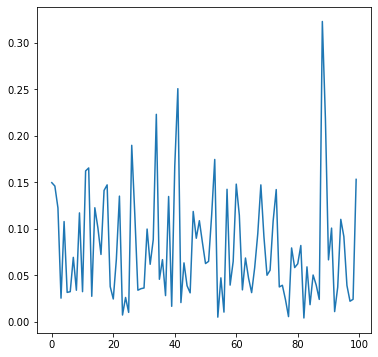

In [118]:
plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [119]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


Epoch 1/20


100%|██████████| 50/50 [00:03<00:00, 16.23it/s, loss=5.651e+02]


  Loss =  1.876e+05
Epoch 2/20


100%|██████████| 50/50 [00:00<00:00, 189.57it/s, loss=5.028e+01]


  Loss =  1.094e+02
Epoch 3/20


100%|██████████| 50/50 [00:00<00:00, 187.02it/s, loss=4.883e+01]


  Loss =  4.994e+01
Epoch 4/20


100%|██████████| 50/50 [00:00<00:00, 187.49it/s, loss=5.426e+01]


  Loss =  4.986e+01
Epoch 5/20


100%|██████████| 50/50 [00:00<00:00, 182.61it/s, loss=4.940e+01]


  Loss =  4.987e+01
Epoch 6/20


100%|██████████| 50/50 [00:00<00:00, 180.27it/s, loss=5.084e+01]


  Loss =  4.988e+01
Epoch 7/20


100%|██████████| 50/50 [00:00<00:00, 190.43it/s, loss=5.014e+01]


  Loss =  4.987e+01
Epoch 8/20


100%|██████████| 50/50 [00:00<00:00, 186.60it/s, loss=4.916e+01]


  Loss =  4.986e+01
Epoch 9/20


100%|██████████| 50/50 [00:00<00:00, 201.99it/s, loss=4.677e+01]


  Loss =  4.987e+01
Epoch 10/20


100%|██████████| 50/50 [00:00<00:00, 201.15it/s, loss=5.072e+01]


  Loss =  4.986e+01
Epoch 11/20


100%|██████████| 50/50 [00:00<00:00, 193.85it/s, loss=4.929e+01]


  Loss =  4.988e+01
Epoch 12/20


100%|██████████| 50/50 [00:00<00:00, 201.47it/s, loss=4.817e+01]


  Loss =  4.987e+01
Epoch 13/20


100%|██████████| 50/50 [00:00<00:00, 206.92it/s, loss=4.986e+01]


  Loss =  4.988e+01
Epoch 14/20


100%|██████████| 50/50 [00:00<00:00, 192.43it/s, loss=5.033e+01]


  Loss =  4.986e+01
Epoch 15/20


100%|██████████| 50/50 [00:00<00:00, 199.32it/s, loss=4.931e+01]


  Loss =  4.985e+01
Epoch 16/20


100%|██████████| 50/50 [00:00<00:00, 203.57it/s, loss=5.032e+01]


  Loss =  4.987e+01
Epoch 17/20


100%|██████████| 50/50 [00:00<00:00, 201.93it/s, loss=4.863e+01]


  Loss =  4.987e+01
Epoch 18/20


100%|██████████| 50/50 [00:00<00:00, 198.96it/s, loss=5.010e+01]


  Loss =  4.988e+01
Epoch 19/20


100%|██████████| 50/50 [00:00<00:00, 207.79it/s, loss=4.823e+01]


  Loss =  4.988e+01
Epoch 20/20


100%|██████████| 50/50 [00:00<00:00, 194.15it/s, loss=4.876e+01]


  Loss =  4.987e+01


In [120]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


Epoch 1/20


100%|██████████| 50/50 [00:00<00:00, 158.80it/s, loss=5.748e+01]


  Loss =  6.392e+04
Epoch 2/20


100%|██████████| 50/50 [00:00<00:00, 154.63it/s, loss=5.157e+01]


  Loss =  5.014e+01
Epoch 3/20


100%|██████████| 50/50 [00:00<00:00, 152.82it/s, loss=4.798e+01]


  Loss =  4.985e+01
Epoch 4/20


100%|██████████| 50/50 [00:00<00:00, 156.94it/s, loss=4.907e+01]


  Loss =  4.984e+01
Epoch 5/20


100%|██████████| 50/50 [00:00<00:00, 153.12it/s, loss=4.623e+01]


  Loss =  4.992e+01
Epoch 6/20


100%|██████████| 50/50 [00:00<00:00, 155.97it/s, loss=5.251e+01]


  Loss =  4.986e+01
Epoch 7/20


100%|██████████| 50/50 [00:00<00:00, 152.21it/s, loss=4.839e+01]


  Loss =  4.983e+01
Epoch 8/20


100%|██████████| 50/50 [00:00<00:00, 149.65it/s, loss=5.076e+01]


  Loss =  4.988e+01
Epoch 9/20


100%|██████████| 50/50 [00:00<00:00, 151.56it/s, loss=4.970e+01]


  Loss =  4.984e+01
Epoch 10/20


100%|██████████| 50/50 [00:00<00:00, 156.59it/s, loss=4.893e+01]


  Loss =  4.979e+01
Epoch 11/20


100%|██████████| 50/50 [00:00<00:00, 151.47it/s, loss=4.852e+01]


  Loss =  4.985e+01
Epoch 12/20


100%|██████████| 50/50 [00:00<00:00, 154.61it/s, loss=5.211e+01]


  Loss =  4.983e+01
Epoch 13/20


100%|██████████| 50/50 [00:00<00:00, 152.60it/s, loss=4.977e+01]


  Loss =  4.984e+01
Epoch 14/20


100%|██████████| 50/50 [00:00<00:00, 150.46it/s, loss=4.907e+01]


  Loss =  4.983e+01
Epoch 15/20


100%|██████████| 50/50 [00:00<00:00, 155.34it/s, loss=5.091e+01]


  Loss =  4.985e+01
Epoch 16/20


100%|██████████| 50/50 [00:00<00:00, 157.77it/s, loss=5.034e+01]


  Loss =  4.982e+01
Epoch 17/20


100%|██████████| 50/50 [00:00<00:00, 152.39it/s, loss=5.313e+01]


  Loss =  4.986e+01
Epoch 18/20


100%|██████████| 50/50 [00:00<00:00, 149.37it/s, loss=4.858e+01]


  Loss =  4.984e+01
Epoch 19/20


100%|██████████| 50/50 [00:00<00:00, 149.20it/s, loss=5.038e+01]


  Loss =  4.980e+01
Epoch 20/20


100%|██████████| 50/50 [00:00<00:00, 144.11it/s, loss=5.099e+01]


  Loss =  4.997e+01


In [121]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

Epoch 1/10


100%|██████████| 1/1 [00:01<00:00,  1.41s/it, loss=1.851e+06]


  Loss =  1.851e+06
Epoch 2/10


100%|██████████| 1/1 [00:00<00:00, 145.46it/s, loss=1.518e+06]


  Loss =  1.518e+06
Epoch 3/10


100%|██████████| 1/1 [00:00<00:00, 119.90it/s, loss=1.249e+06]


  Loss =  1.249e+06
Epoch 4/10


100%|██████████| 1/1 [00:00<00:00, 120.31it/s, loss=1.029e+06]


  Loss =  1.029e+06
Epoch 5/10


100%|██████████| 1/1 [00:00<00:00, 131.40it/s, loss=8.504e+05]


  Loss =  8.504e+05
Epoch 6/10


100%|██████████| 1/1 [00:00<00:00, 99.20it/s, loss=7.042e+05]


  Loss =  7.042e+05
Epoch 7/10


100%|██████████| 1/1 [00:00<00:00, 132.71it/s, loss=5.843e+05]


  Loss =  5.843e+05
Epoch 8/10


100%|██████████| 1/1 [00:00<00:00, 137.98it/s, loss=4.855e+05]


  Loss =  4.855e+05
Epoch 9/10


100%|██████████| 1/1 [00:00<00:00, 142.73it/s, loss=4.040e+05]


  Loss =  4.040e+05
Epoch 10/10


100%|██████████| 1/1 [00:00<00:00, 113.80it/s, loss=3.368e+05]

  Loss =  3.368e+05


In [122]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


Epoch 1/10


100%|██████████| 1/1 [00:00<00:00, 66.94it/s, loss=1.143e+06]


  Loss =  1.143e+06
Epoch 2/10


100%|██████████| 1/1 [00:00<00:00, 74.76it/s, loss=4.006e+05]


  Loss =  4.006e+05
Epoch 3/10


100%|██████████| 1/1 [00:00<00:00, 74.50it/s, loss=1.423e+05]


  Loss =  1.423e+05
Epoch 4/10


100%|██████████| 1/1 [00:00<00:00, 66.86it/s, loss=1.066e+05]


  Loss =  1.066e+05
Epoch 5/10


100%|██████████| 1/1 [00:00<00:00, 72.15it/s, loss=6.252e+04]


  Loss =  6.252e+04
Epoch 6/10


100%|██████████| 1/1 [00:00<00:00, 69.93it/s, loss=5.580e+04]


  Loss =  5.580e+04
Epoch 7/10


100%|██████████| 1/1 [00:00<00:00, 79.09it/s, loss=4.906e+04]


  Loss =  4.906e+04
Epoch 8/10


100%|██████████| 1/1 [00:00<00:00, 73.89it/s, loss=4.055e+04]


  Loss =  4.055e+04
Epoch 9/10


100%|██████████| 1/1 [00:00<00:00, 59.28it/s, loss=2.980e+04]


  Loss =  2.980e+04
Epoch 10/10


100%|██████████| 1/1 [00:00<00:00, 84.50it/s, loss=1.775e+04]


  Loss =  1.775e+04


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-6
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

Epoch 1/20 

100%|██████████| 50/50 [00:00<00:00, 583.62it/s, grad=3.390e+04, loss=1.624e+05]


  |Grad| = 8.355e+04
  Loss = 8.667e+05
Epoch 2/20 

100%|██████████| 50/50 [00:00<00:00, 594.98it/s, grad=9.179e+03, loss=1.217e+04]


  |Grad| = 2.141e+04
  Loss = 6.118e+04
Epoch 3/20 

100%|██████████| 50/50 [00:00<00:00, 551.99it/s, grad=3.905e+03, loss=1.450e+03]


  |Grad| = 6.372e+03
  Loss = 5.425e+03
Epoch 4/20 

100%|██████████| 50/50 [00:00<00:00, 551.85it/s, grad=1.346e+03, loss=2.368e+02]


  |Grad| = 1.991e+03
  Loss = 5.799e+02
Epoch 5/20 

100%|██████████| 50/50 [00:00<00:00, 578.05it/s, grad=3.842e+02, loss=6.729e+01]


  |Grad| = 6.475e+02
  Loss = 1.067e+02
Epoch 6/20 

100%|██████████| 50/50 [00:00<00:00, 603.14it/s, grad=1.658e+02, loss=5.299e+01]


  |Grad| = 2.368e+02
  Loss = 5.649e+01
Epoch 7/20 

  0%|          | 0/50 [00:00<?, ?it/s, grad=1.265e+02, loss=4.901e+01]

In [ ]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
#plt.semilogy(loss_o)
plt.semilogy(loss_os)
#plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* Make the Hessian illconditioned rather than the operator(s) $A$ (how? maybe not worth it)
* Implement some kind of warm up /estimation of $D_0$
* Run on CryoEM data